In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [5]:
def parse_dat_file_to_dataframe(file_path):
    # List to store event data (each event is a dict)
    events_data = []
    current_event = {}
    event_number = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing spaces
            
            # Detect the start of a new event
            event_match = re.match(r'% Event (\d+)', line)
            if event_match:
                # If we are in the middle of an event, store it before moving to the next one
                if current_event:
                    events_data.append(current_event)
                    current_event = {}
                
                # Start a new event
                event_number = int(event_match.group(1))
                current_event['Event'] = event_number
            
            # Split the key-value pairs and store them in the current_event dict
            elif line and not line.startswith('%'):
                key_value = line.split('\t')
                if len(key_value) == 2:
                    key, value = key_value
                    current_event[key] = float(value) if value.replace('.', '', 1).isdigit() else value

        # Append the last event after reading the file
        if current_event:
            events_data.append(current_event)
    
    # Convert list of event dictionaries to a DataFrame
    df = pd.DataFrame(events_data)
    
    return df

In [71]:
folder = "O:/Nat_ASVAP/OMLAB_DATA/ASVAP_press_"
month = "Oct2024/"
run = "Run-002"

start_file = 1
path_intial = folder+month+run+"/"+run+f"-00{start_file}.dat"
path = folder+month+run
num_files = 69


In [72]:
df = parse_dat_file_to_dataframe(path_intial)
for i in range(start_file+1,num_files+1):
    
    if i <10:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-00{i}.dat")
    elif 10 <= i <100:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-0{i}.dat")
    elif 100 <= i:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-{i}.dat")
    df = pd.concat([df,next_file],ignore_index=True)
zero_indices = df.index[df['Some_calibration'] == 0.0].tolist()
df = df.drop(index=zero_indices).reset_index(drop=True)

In [73]:
def linfunc(x, a, b):
    return x*a + b

def expfunc(x, a, b ,c):
    return a* np.exp(b * x ) + c

def lnfunc(x,a,b,c):
    return  a*np.log(b*x) + c

intial_guess = [10,0.001,60]

data_start, data_stop = 0,-1

func = expfunc

xdata = ((df["Time_ms"]-df["Time_ms"][0])*2.7778*10**(-7)) #Time in hours
# ydata = df["TC_CH8_TransCh_C"]#.astype(float) * 10**(-7) #convert to 1e-7 mbar
ydata = df["TC_CH1_Samp_C"].astype(float)
popt, pcov = curve_fit(func, xdata[data_start:data_stop],ydata[data_start:data_stop], p0=intial_guess, maxfev=10000 )
print(popt, np.diag(pcov))

[-38.21478214  -4.10325643  34.4057341 ] [3.22174082e-04 1.09736159e-05 1.93459352e-05]


Text(0.5, 1.0, 'Heating of sample holder (-4 C) in main chamber to Room temp, Oct2024/Run-002')

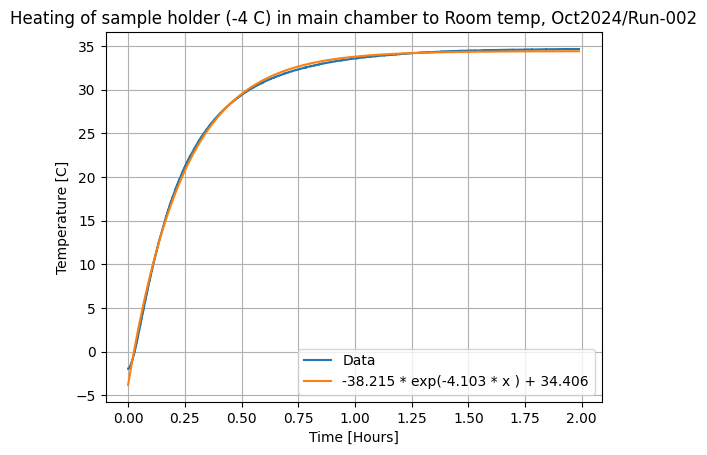

In [74]:
plt.plot(xdata,ydata, label="Data")
if func == expfunc:
    plt.plot(xdata[data_start:data_stop], expfunc(xdata[data_start:data_stop],*popt), label="{:.3f} * exp({:.3f} * x ) + {:.3f}".format(*popt))
elif func == linfunc:
    plt.plot(xdata, linfunc(xdata,*popt), label="{:.7f}*x + {:.7f}".format(*popt))
elif func == lnfunc:
    plt.plot(xdata[data_start:data_stop], lnfunc(xdata[data_start:data_stop], *popt), label="{} * ln({} * x) + {}".format(*popt))
plt.xlabel("Time [Hours]")
plt.ylabel("Temperature [C]")
plt.grid()
plt.legend()
# plt.xscale("log")
plt.title("Heating of sample holder (-4 C) in main chamber to Room temp, {}".format(month+run))
# plt.savefig("cooling of sample holder to -4 C run 33")

34.20985849993102


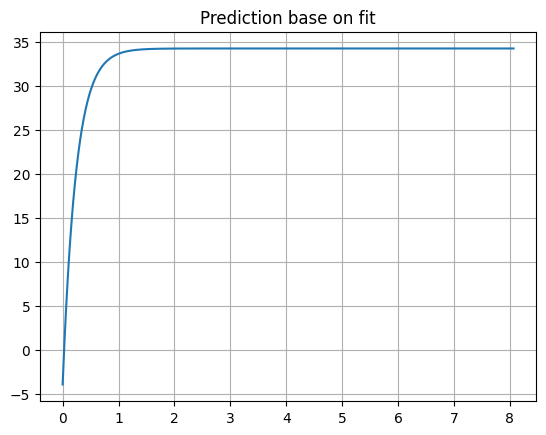

In [63]:
x = np.linspace(0,xdata.tolist()[-1]*5, 10000)
plt.plot(x, expfunc(x, *popt))
plt.title("Prediction base on fit")
plt.grid()
print(expfunc(1.5, *popt) )

In [64]:
df

,Some_calibration,Event,DAQ_TimeStamp_UTC,Time_ms,PT_1_Chvalve_C,PT_2_Chtop_C,PT_3_free_C,PT_4_Chbot_C,TC_int,TC_CH1_Samp_C,...,G4_Not_Connected_value_1e7mbar,G4_Not_Connected_status,G5_Main_Barocel_value_1e7mbar,G5_Main_Barocel_status,G6_Main_Inficone_value_1e7mbar,G6_Main_Inficone_status,Valve_pre_chamber,Valve_turbo_main_chamber,Valve_ion_main_chamber,Valve_aux
0,NaN,1.0,02-10-2024 13:22:40,771490069.0,38.380,34.350,20.415,34.995,20.996494,-1.943517,...,0.0,0.0,600.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
1,NaN,2.0,02-10-2024 13:22:40,771490671.0,38.375,34.350,20.415,34.988,20.996494,-1.943517,...,0.0,0.0,600.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
2,NaN,3.0,02-10-2024 13:22:42,771492177.0,38.375,34.348,20.415,34.988,20.996494,-1.943517,...,0.0,0.0,600.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
3,NaN,4.0,02-10-2024 13:22:42,771492678.0,38.375,34.348,20.412,34.985,20.996904,-1.958421,...,0.0,0.0,600.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
4,NaN,5.0,02-10-2024 13:22:44,771494184.0,38.384,34.348,20.412,34.985,20.996904,-1.958421,...,0.0,0.0,600.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,NaN,5596.0,02-10-2024 14:59:24,777294637.0,38.333,34.369,20.592,34.984,21.524273,34.522049,...,0.0,0.0,510.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
5596,NaN,5597.0,02-10-2024 14:59:26,777296144.0,38.333,34.369,20.592,34.984,21.524273,34.514698,...,0.0,0.0,510.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
5597,NaN,5598.0,02-10-2024 14:59:27,777296744.0,38.339,34.366,20.593,34.984,21.524273,34.514698,...,0.0,0.0,510.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
5598,NaN,5599.0,02-10-2024 14:59:28,777298251.0,38.339,34.366,20.593,34.976,21.524132,34.53664,...,0.0,0.0,510.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
